In [1]:
import datetime
from fermi.tipsh import sidak, level_key
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mmappickle.dict import mmapdict
import numpy
import pandas as pd
from scipy.stats import poisson, skellam
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri

numpy2ri.activate()

stats = importr("stats")
skel = importr("skellam")

In [2]:
energy = '500-1000gev'
fits_root = 'fits_files'
data = 'constant'
now = datetime.date.today()

In [3]:
def coeff_std(J, j, alpha_j):
    N = (4**j)/2
    ub = math.floor(skellam.isf(alpha_j/2, N, N))
    lb = math.floor(skellam.ppf(alpha_j/2, N, N))
    e = 0
    for x in range(ub, math.ceil(10*math.sqrt(2*N))):
        e = e + x*x*skellam.pmf(x, N, N)
    for x in range(lb, -math.ceil(10*math.sqrt(2*N)), -1):
        e = e + x*x*skellam.pmf(x, N, N)
    return math.sqrt(e)

In [6]:
def level_stats(J, alpha, fwer_fn, m):
    rows = []
    for j in range(1, J+1):
        alpha_j = fwer_fn(alpha, J-j)
        N = (4**j)/2
        countsError = skellam.isf(alpha_j/2, N, N) if alpha_j/2 < 0.5 else skellam.ppf(alpha_j/2, N, N)
        measuredStd = (numpy.std(m[level_key('wavelet', 'hs', j)]) + numpy.std(m[level_key('wavelet', 'vs', j)]) + numpy.std(m[level_key('wavelet', 'ds', j)]))/3
        measuredFalse = (numpy.count_nonzero(m[level_key('wavelet', 'hs', j)] != 0) + numpy.count_nonzero(m[level_key('wavelet', 'vs', j)] != 0) + 
                         numpy.count_nonzero(m[level_key('wavelet', 'ds', j)] != 0))/(3*2**(2*j))
        rows.append([2**j, N, alpha_j, 2**(2*(J-j)), countsError, alpha_j*2**(2*(J-j)), measuredFalse, coeff_std(J, j, alpha_j), measuredStd])
    return pd.DataFrame(rows, index=pd.Index(range(1,J+1), name='j'), columns=['Size', 'Expected', 'alpha', '# Tests', 'Coeff Threshold (+/-)', 'False Detection (Expected)', 'False Detection (Measured)', 
                                                                               'Coeff Std (Expected)', 'Coeff Std (Measured)'])

In [11]:
J = 12
fwer = 'uniform'
alpha = 1e-6
wavelet_filename = f"{data}_{now}_{energy}_{fwer}_{alpha}.mmdpickle"
m = mmapdict(wavelet_filename)
level_stats(J, alpha, lambda alpha, j: alpha, m)

,Size,Expected,alpha,# Tests,Coeff Threshold (+/-),False Detection (Expected),False Detection (Measured),Coeff Std (Expected),Coeff Std (Measured)
j,,,,,,,,,
1,2,2.0,0.000001,4194304,11.0,4.194304,2.000000,0.019751,0.009378
2,4,8.0,0.000001,1048576,20.0,1.048576,1.000000,0.034376,0.023623
3,8,32.0,0.000001,262144,40.0,0.262144,0.114583,0.042693,0.030547
4,16,128.0,0.000001,65536,79.0,0.065536,0.057292,0.081879,0.083867
5,32,512.0,0.000001,16384,157.0,0.016384,0.000651,0.164788,0.021082
6,64,2048.0,0.000001,4096,313.0,0.004096,0.001953,0.333112,0.225902
7,128,8192.0,0.000001,1024,626.0,0.001024,0.001221,0.658882,0.560482
8,256,32768.0,0.000001,256,1252.0,0.000256,0.000153,1.311101,0.641170
9,512,131072.0,0.000001,64,2505.0,0.000064,0.000000,2.603894,0.000000


In [12]:
J = 12
fwer = 'uniform'
alpha = 0.01
wavelet_filename = f"{data}_{now}_{energy}_{fwer}_{alpha}.mmdpickle"
m = mmapdict(wavelet_filename)
level_stats(J, alpha, lambda alpha, j: alpha, m)

,Size,Expected,alpha,# Tests,Coeff Threshold (+/-),False Detection (Expected),False Detection (Measured),Coeff Std (Expected),Coeff Std (Measured)
j,,,,,,,,,
1,2,2.0,0.01,4194304,5.0,41943.04,24886.833333,0.878162,0.557761
2,4,8.0,0.01,1048576,10.0,10485.76,7437.708333,1.480757,1.144177
3,8,32.0,0.01,262144,21.0,2621.44,1472.854167,2.382216,2.059025
4,16,128.0,0.01,65536,41.0,655.36,487.859375,4.900216,4.605144
5,32,512.0,0.01,16384,82.0,163.84,122.767578,9.615664,9.152245
6,64,2048.0,0.01,4096,165.0,40.96,31.320475,18.722636,18.406351
7,128,8192.0,0.01,1024,330.0,10.24,8.871989,37.275777,39.548339
8,256,32768.0,0.01,256,659.0,2.56,2.712443,74.714818,88.563315
9,512,131072.0,0.01,64,1319.0,0.64,0.571874,148.932841,162.494072


In [13]:
J = 12
fwer = 'uniform'
alpha = 0.99
wavelet_filename = f"{data}_{now}_{energy}_{fwer}_{alpha}.mmdpickle"
m = mmapdict(wavelet_filename)
level_stats(J, alpha, lambda alpha, j: alpha, m)

,Size,Expected,alpha,# Tests,Coeff Threshold (+/-),False Detection (Expected),False Detection (Measured),Coeff Std (Expected),Coeff Std (Measured)
j,,,,,,,,,
1,2,2.0,0.99,4194304,0.0,4152360.96,2.569022e+06,2.000000,2.000354
2,4,8.0,0.99,1048576,0.0,1038090.24,7.286057e+05,4.000000,4.001328
3,8,32.0,0.99,262144,0.0,259522.56,1.923786e+05,8.000000,7.996899
4,16,128.0,0.99,65536,0.0,64880.64,4.936137e+04,16.000000,16.004228
5,32,512.0,0.99,16384,0.0,16220.16,1.249689e+04,32.000000,31.859392
6,64,2048.0,0.99,4096,1.0,4055.04,3.144352e+03,64.000000,63.983015
7,128,8192.0,0.99,1024,2.0,1013.76,7.836571e+02,127.999976,129.495117
8,256,32768.0,0.99,256,3.0,253.44,1.956370e+02,255.999970,263.888308
9,512,131072.0,0.99,64,6.0,63.36,4.892962e+01,511.999916,510.275623


In [10]:
J = 12
fwer = 'sidak'
alpha = 0.01
wavelet_filename = f"{data}_{now}_{energy}_{fwer}_{alpha}.mmdpickle"
m = mmapdict(wavelet_filename)
level_stats(J, alpha, sidak, m)

,Size,Expected,alpha,# Tests,Coeff Threshold (+/-),False Detection (Expected),False Detection (Measured),Coeff Std (Expected),Coeff Std (Measured)
j,,,,,,,,,
1,2,2.0,2.396187e-09,4194304,14.0,0.010050,0.000000,0.001437,0.000000
2,4,8.0,9.584747e-09,1048576,24.0,0.010050,0.041667,0.004076,0.003274
3,8,32.0,3.833899e-08,262144,45.0,0.010050,0.000000,0.009628,0.000000
4,16,128.0,1.533559e-07,65536,84.0,0.010050,0.010417,0.038664,0.030507
5,32,512.0,6.134236e-07,16384,160.0,0.010050,0.000651,0.132009,0.021082
6,64,2048.0,2.453692e-06,4096,302.0,0.010050,0.004883,0.494634,0.345232
7,128,8192.0,9.814733e-06,1024,566.0,0.010050,0.017863,1.871363,2.538718
8,256,32768.0,3.925835e-05,256,1053.0,0.010050,0.029195,6.964260,11.775012
9,512,131072.0,1.570242e-04,64,1935.0,0.010050,0.016202,25.869818,34.533952


In [7]:
J = 12
fwer = 'sidak'
alpha = 0.99
wavelet_filename = f"{data}_{now}_{energy}_{fwer}_{alpha}.mmdpickle"
m = mmapdict(wavelet_filename)
level_stats(J, alpha, sidak, m)

,Size,Expected,alpha,# Tests,Coeff Threshold (+/-),False Detection (Expected),False Detection (Measured),Coeff Std (Expected),Coeff Std (Measured)
j,,,,,,,,,
1,2,2.0,0.000001,4194304,11.0,4.605168,2.000000,0.019751,0.009378
2,4,8.0,0.000004,1048576,19.0,4.605160,2.750000,0.055707,0.037526
3,8,32.0,0.000018,262144,35.0,4.605130,2.375000,0.159274,0.127118
4,16,128.0,0.000070,65536,64.0,4.605008,4.437500,0.580932,0.629780
5,32,512.0,0.000281,16384,116.0,4.604523,3.088542,2.170967,1.935600
6,64,2048.0,0.001124,4096,208.0,4.602582,3.187012,7.757940,7.134770
7,128,8192.0,0.004487,1024,364.0,4.594830,4.157104,27.061712,29.264102
8,256,32768.0,0.017828,256,607.0,4.563996,4.525889,93.025451,107.225602
9,512,131072.0,0.069428,64,930.0,4.443389,3.327965,302.136406,302.304507


In [83]:
y, x = numpy.mgrid[0:5:1,0:5:1]
h = numpy.ones((4,4))
h[:, 2:4] = -1
v = numpy.ones((4,4))
v[2:4,:] = -1
d = numpy.ones((4,4))
d[0:2, 0:2] = -1
d[2:4, 2:4] = -1
s = numpy.ones((4,4))
wavelets = {'Scaling':s, 'Horizontal':h, 'Vertical':v, 'Diagonal':d}

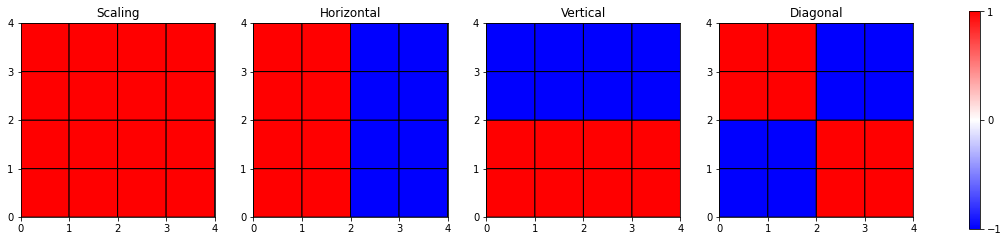

In [90]:
fig, axs = plt.subplots(1,4, figsize=(20,4))
i = 0
for k in wavelets:
    ax = axs[i]
    c = ax.pcolor(x, y, wavelets[k], cmap=plt.cm.bwr, edgecolors='k', linewidths=1, norm=colors.Normalize(vmin=-1,vmax=1))
    ax.set_aspect('equal', 'box')
    ax.set_title(k)
    ax.xaxis.set_ticks(range(0,5))
    ax.yaxis.set_ticks(range(0,5))
    i += 1
fig.colorbar(c, ax=axs, ticks=[-1, 0, 1])